In [1]:
import xarray as xr
import numpy as np
import torch
import pandas as pd

import scipy.stats

import matplotlib.pyplot as plt

from ens_transformer.data_module import IFSERADataModule

In [2]:
plt.style.use('paper')
plt.style.use('egu_journals')

In [3]:
data_module = IFSERADataModule(pin_memory=False)

In [4]:
data_module.setup()

In [5]:
prediction_paths = {
    'transformer': '../data/processed/prediction/transformer_scale/transformer_5_20.nc',
    'ppnn': '../data/processed/prediction/baseline_scale/ppnn_5_20.nc',
}

In [6]:
xr_pred = {pred_name: xr.open_dataset(pred_path) for pred_name, pred_path in prediction_paths.items()}

In [7]:
xr_pred['raw'] = xr.Dataset({
    'mean': data_module.ds_test.ifs.sel(var_name='t2m').mean('ensemble')-273.15,
    'stddev': data_module.ds_test.ifs.sel(var_name='t2m').std('ensemble', ddof=1)
})

# CDFs from Gaussian

In [8]:
raw_cdf_vals = scipy.stats.norm(
    loc=xr_pred['raw']['mean'].values,
    scale=xr_pred['raw']['stddev'].values
).cdf(data_module.ds_test.era5.values)

In [9]:
ppnn_cdf_vals = scipy.stats.norm(
    loc=xr_pred['ppnn']['mean'].values,
    scale=xr_pred['ppnn']['stddev'].values
).cdf(data_module.ds_test.era5.values)

# Ranks from members

In [10]:
def rank_from_members(xr_members, xr_obs):
    n_members = float(len(xr_members['ensemble']))
    axis_ens = xr_members.get_axis_num('ensemble')
    sorted_members = np.sort(xr_members.values, axis=axis_ens)
    sorted_members = xr_members.copy(data=sorted_members)
    obs_larger = sorted_members<xr_obs
    rank = obs_larger.argmin('ensemble')
    rank = rank.where(~obs_larger.all('ensemble'), n_members)
    return rank

In [11]:
raw_rank_vals = rank_from_members(data_module.ds_test.ifs.sel(var_name='t2m')-273.15, data_module.ds_test.era5)

In [12]:
trans_rank_vals = rank_from_members(xr_pred['transformer']['members'], data_module.ds_test.era5)

Text(0, 0.5, 'Counts')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


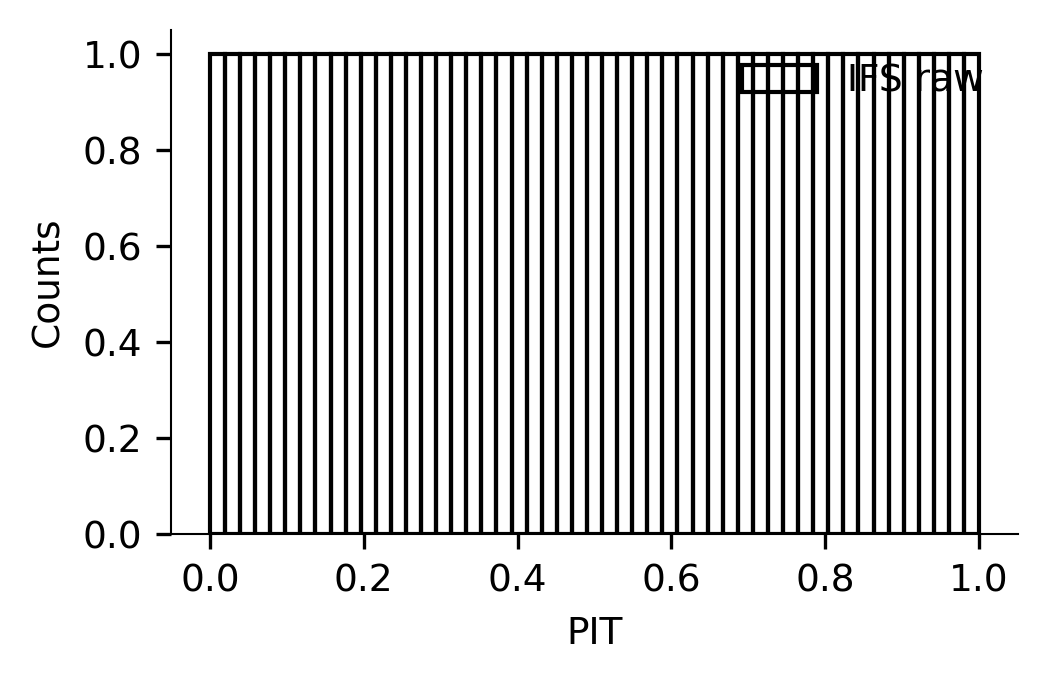

In [13]:
figsize = [s*0.48 for s in plt.rcParams['figure.figsize']]
fig, ax = plt.subplots(figsize=figsize, dpi=300);
hist_return = ax.hist(np.arange(51) / 50., bins=51, ec='black', fc='None', label='IFS raw')

ax.set_xlim(-0.05, 1.05)
ax.legend()
ax.set_xlabel('PIT')
ax.set_ylabel('Counts')

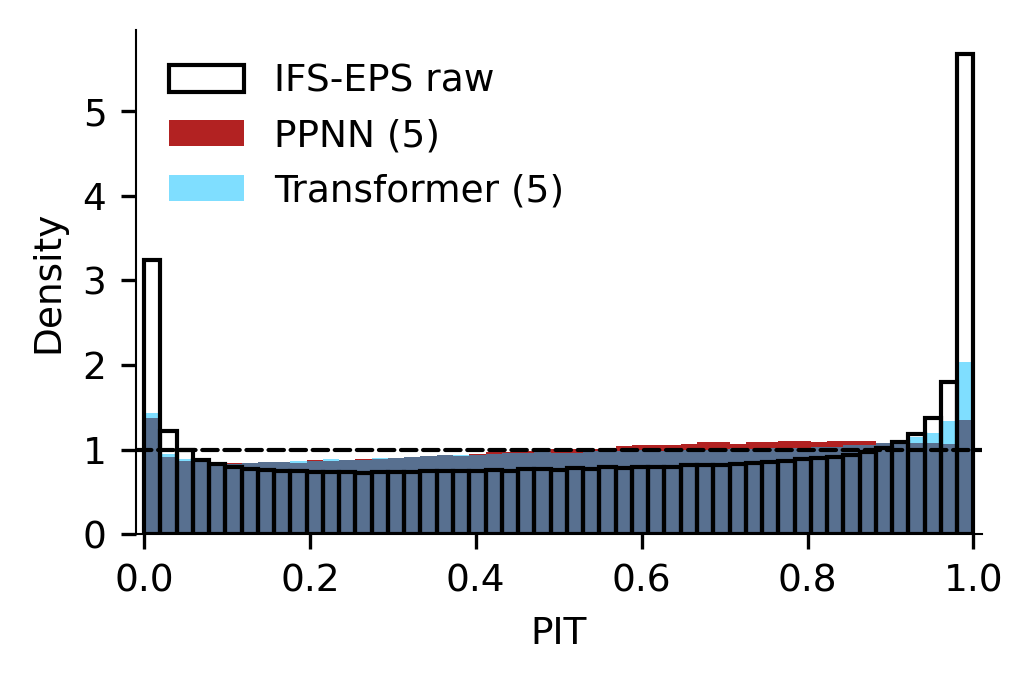

In [15]:
figsize = [s*0.48 for s in plt.rcParams['figure.figsize']]
fig, ax = plt.subplots(figsize=figsize, dpi=300)
ax.hist(raw_rank_vals.values.flatten() / 50., bins=hist_return[1], ec='black', fc='None', label='IFS-EPS raw', density=True, zorder=99)
ax.hist(ppnn_cdf_vals.flatten(), bins=hist_return[1], alpha=1., fc='firebrick', label='PPNN (5)', density=True)
ax.hist(trans_rank_vals.values.flatten() / 50., bins=hist_return[1], alpha=0.5, fc='deepskyblue', label='Transformer (5)', density=True)
ax.axhline(y=1, c='black', ls='--', linewidth=1.0)
#ax.hist(np.arange(51) / 50., bins=51, ec='black', fc='None', label='IFS raw')

ax.set_xlim(-0.01, 1.01)
ax.legend()
ax.set_xlabel('PIT')
ax.set_ylabel('Density')
fig.savefig('../paper/figures/fig_pit.png', dpi=300)